In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import set_config
from sklearn.ensemble import RandomForestClassifier

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler)
from feature_engine.encoding import RareLabelEncoder
from feature_engine.outliers import Winsorizer

import mlflow
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay)

In [3]:
df = sns.load_dataset('titanic')
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [4]:
df.isna().sum()

survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           688
embark_town      2
alive            0
alone            0
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


In [6]:
df['family'] = df['sibsp'] + df['parch']

In [7]:
df.drop(columns=['sibsp','parch'],inplace=True)

In [8]:
df.drop(columns=['alone', 'who', 'class', 'deck', 'embark_town', 'adult_male','alive'],inplace=True)

In [9]:
df.shape

(891, 7)

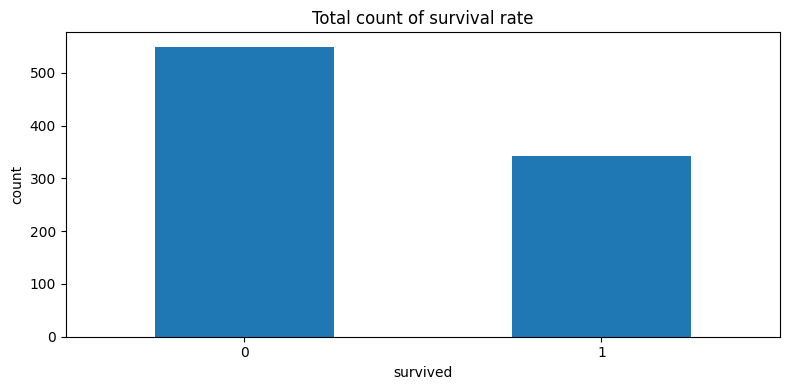

In [10]:
plt.figure(figsize=(8,4))
df['survived'].value_counts().plot(kind='bar')
plt.xlabel('survived')
plt.ylabel('count')
plt.title('Total count of survival rate')
plt.xticks(rotation = 0)
plt.tight_layout()

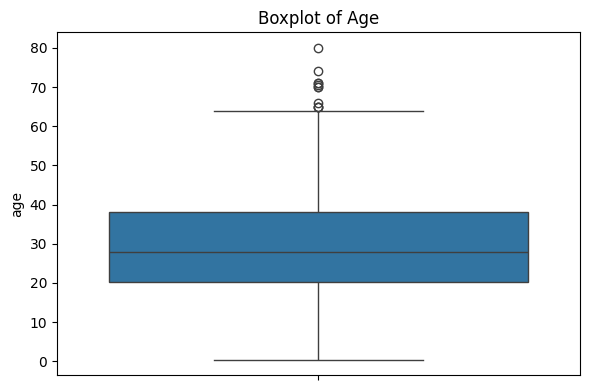

In [11]:
plt.figure(figsize=(6,4))
sns.boxplot(df['age'])
plt.title('Boxplot of Age')
plt.tight_layout()

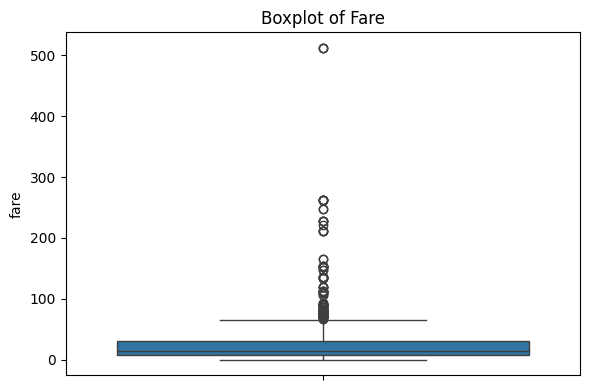

In [12]:
plt.figure(figsize=(6,4))
sns.boxplot(df['fare'])
plt.title('Boxplot of Fare')
plt.tight_layout()

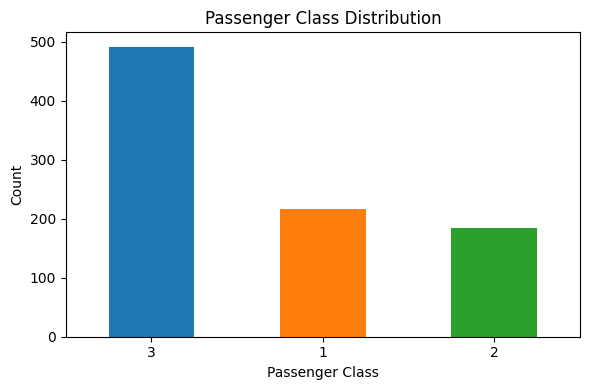

In [13]:
plt.figure(figsize=(6, 4))
df['pclass'].value_counts().plot(kind='bar', color=['C0', 'C1', 'C2'])
plt.xlabel('Passenger Class')
plt.ylabel('Count')
plt.title('Passenger Class Distribution')
plt.xticks(rotation=0)
plt.tight_layout()

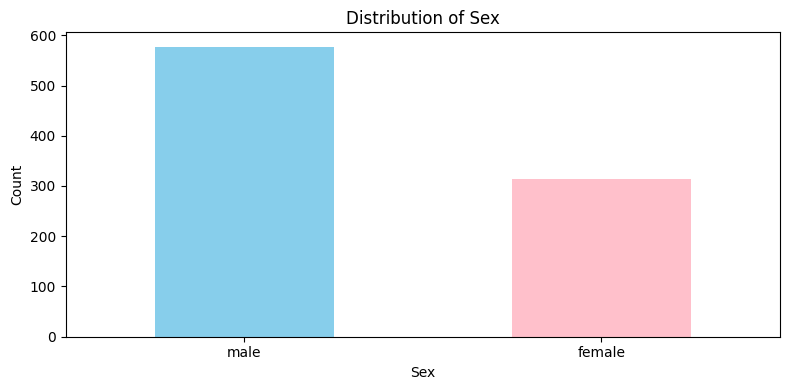

In [14]:
# Create a bar plot
plt.figure(figsize=(8, 4))
df['sex'].value_counts().plot(kind='bar',color=['skyblue','pink'])
plt.xlabel('Sex')
plt.ylabel('Count')
plt.title('Distribution of Sex')
plt.xticks(rotation=0)
plt.tight_layout()

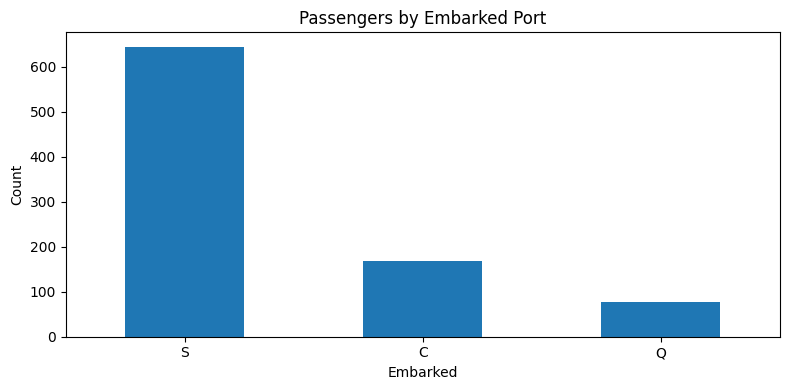

In [15]:
plt.figure(figsize=(8, 4))
df['embarked'].value_counts().plot(kind='bar')
plt.xlabel('Embarked')
plt.ylabel('Count')
plt.title('Passengers by Embarked Port')
plt.xticks(rotation=0)
plt.tight_layout()

In [16]:
X = df.drop('survived', axis=1)
y = df['survived']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
# age pipeline
age_pipe = Pipeline(steps=[
    ('inpute', SimpleImputer(strategy='median')),
    ('outliers', Winsorizer(capping_method='gaussian',fold=3)),
    ('scale', StandardScaler())
])

age_pipe

Pipeline(steps=[('inpute', SimpleImputer(strategy='median')),
                ('outliers', Winsorizer(fold=3)), ('scale', StandardScaler())])

In [19]:
# fare pipeline
fare_pipe = Pipeline(steps=[
    ('outliers', Winsorizer(capping_method='iqr',fold=1.5)),
    ('scale', StandardScaler())
])

fare_pipe

Pipeline(steps=[('outliers', Winsorizer(capping_method='iqr', fold=1.5)),
                ('scale', StandardScaler())])

In [20]:
# Embarked pipeline
from feature_engine.encoding import CountFrequencyEncoder

embarked_pipe = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('count_encode', CountFrequencyEncoder(encoding_method='count')),
    ('scale', MinMaxScaler())
])

embarked_pipe

Pipeline(steps=[('impute', SimpleImputer(strategy='most_frequent')),
                ('count_encode', CountFrequencyEncoder()),
                ('scale', MinMaxScaler())])

In [21]:
# Output transformed data as pandas Dataframe
set_config(transform_output='pandas')

In [22]:
# make column transformer
preprocessor = ColumnTransformer(transformers=[
    ('age', age_pipe, ['age']),
    ('fare', fare_pipe, ['fare']),
    ('embarked', embarked_pipe, ['embarked']),
    ('sex', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), ['sex']),
    ('family', MinMaxScaler(), ['family'])
], remainder='passthrough', n_jobs=-1, force_int_remainder_cols = False)

preprocessor

ColumnTransformer(force_int_remainder_cols=False, n_jobs=-1,
                  remainder='passthrough',
                  transformers=[('age',
                                 Pipeline(steps=[('inpute',
                                                  SimpleImputer(strategy='median')),
                                                 ('outliers',
                                                  Winsorizer(fold=3)),
                                                 ('scale', StandardScaler())]),
                                 ['age']),
                                ('fare',
                                 Pipeline(steps=[('outliers',
                                                  Winsorizer(capping_method='iqr',
                                                             fold=1.5)),
                                                 ('scale', StandardScaler())]),
                                 ['fare']),
                                ('embarked',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('count_encode',
                                                  CountFrequencyEncoder()),
                                                 ('scale', MinMaxScaler())]),
                                 ['embarked']),
                                ('sex',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse_output=False),
                                 ['sex']),
                                ('family', MinMaxScaler(), ['family'])])

In [23]:
# Fit and transform the training data
preprocessor.fit_transform(X_train)

,age__age,fare__fare,embarked__embarked,sex__sex_female,sex__sex_male,family__family,remainder__pclass
331,1.266850,0.236751,1.0,0.0,1.0,0.0,1
733,-0.478777,-0.532339,1.0,0.0,1.0,0.0,2
382,0.219474,-0.784153,1.0,0.0,1.0,0.0,3
704,-0.246027,-0.787666,1.0,0.0,1.0,0.1,3
813,-1.797695,0.374443,1.0,1.0,0.0,0.6,3
...,...,...,...,...,...,...,...
106,-0.633944,-0.797799,1.0,1.0,0.0,0.0,3
270,-0.090860,0.360798,1.0,0.0,1.0,0.0,1
860,0.917724,-0.477346,1.0,0.0,1.0,0.2,3
435,-1.177028,2.016201,1.0,1.0,0.0,0.3,1


In [24]:
preprocessor.get_params(deep=False)

{'force_int_remainder_cols': False,
 'n_jobs': -1,
 'remainder': 'passthrough',
 'sparse_threshold': 0.3,
 'transformer_weights': None,
 'transformers': [('age',
   Pipeline(steps=[('inpute', SimpleImputer(strategy='median')),
                   ('outliers', Winsorizer(fold=3)), ('scale', StandardScaler())]),
   ['age']),
  ('fare',
   Pipeline(steps=[('outliers', Winsorizer(capping_method='iqr', fold=1.5)),
                   ('scale', StandardScaler())]),
   ['fare']),
  ('embarked',
   Pipeline(steps=[('impute', SimpleImputer(strategy='most_frequent')),
                   ('count_encode', CountFrequencyEncoder()),
                   ('scale', MinMaxScaler())]),
   ['embarked']),
  ('sex',
   OneHotEncoder(handle_unknown='ignore', sparse_output=False),
   ['sex']),
  ('family', MinMaxScaler(), ['family'])],
 'verbose': False,
 'verbose_feature_names_out': True}

In [25]:
RandomForestClassifier().get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [26]:
# Model Pipeline

model_params = {'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 120,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [27]:
model_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', RandomForestClassifier(**model_params))
])

In [28]:
# Fit the model on the training data
model_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(force_int_remainder_cols=False, n_jobs=-1,
                                   remainder='passthrough',
                                   transformers=[('age',
                                                  Pipeline(steps=[('inpute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('outliers',
                                                                   Winsorizer(fold=3)),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['age']),
                                                 ('fare',
                                                  Pipeline(steps=[('outliers',
                                                                   Winsorizer(capping_method='iqr',
                                                                              fold=1.5)),
                                                                  ('sca...
                                                                   StandardScaler())]),
                                                  ['fare']),
                                                 ('embarked',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('count_encode',
                                                                   CountFrequencyEncoder()),
                                                                  ('scale',
                                                                   MinMaxScaler())]),
                                                  ['embarked']),
                                                 ('sex',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['sex']),
                                                 ('family', MinMaxScaler(),
                                                  ['family'])])),
                ('clf', RandomForestClassifier(max_depth=8, n_estimators=120))])

In [29]:
# Evaluate the model on test data
y_pred = model_pipe.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred).item()
recall = recall_score(y_test, y_pred).item()
f1 = f1_score(y_test, y_pred).item()

In [30]:
# metrics dict

metrics = {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1_score': f1
}

metrics

{'accuracy': 0.8324022346368715,
 'precision': 0.8333333333333334,
 'recall': 0.7432432432432432,
 'f1_score': 0.7857142857142857}

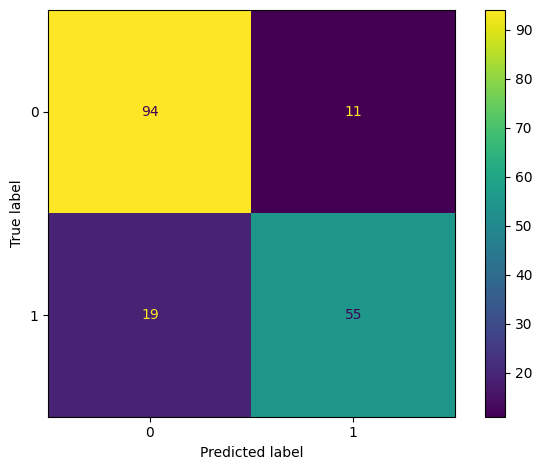

In [31]:
# plot confusion matrix
cm = ConfusionMatrixDisplay.from_predictions(y_test,y_pred)
plt.tight_layout()

In [32]:
# MLflow Tracking code
model_pipe.get_params(deep=False)

{'memory': None,
 'steps': [('preprocessor',
   ColumnTransformer(force_int_remainder_cols=False, n_jobs=-1,
                     remainder='passthrough',
                     transformers=[('age',
                                    Pipeline(steps=[('inpute',
                                                     SimpleImputer(strategy='median')),
                                                    ('outliers',
                                                     Winsorizer(fold=3)),
                                                    ('scale', StandardScaler())]),
                                    ['age']),
                                   ('fare',
                                    Pipeline(steps=[('outliers',
                                                     Winsorizer(capping_method='iqr',
                                                                fold=1.5)),
                                                    ('scale', StandardScaler())]),
                             

In [33]:
X_test.join(y_test)

,pclass,sex,age,fare,embarked,family,survived
709,3,male,NaN,15.2458,C,2,1
439,2,male,31.0,10.5000,S,0,0
840,3,male,20.0,7.9250,S,0,0
720,2,female,6.0,33.0000,S,1,1
39,3,female,14.0,11.2417,C,1,1
...,...,...,...,...,...,...,...
433,3,male,17.0,7.1250,S,0,0
773,3,male,NaN,7.2250,C,0,0
25,3,female,38.0,31.3875,S,6,1
84,2,female,17.0,10.5000,S,0,1


In [38]:
# check if uri is set
mlflow.is_tracking_uri_set()

True

Run all the mlflow realted tracking code in a single cell

In [37]:
# Set the tracking uri
import mlflow.models


mlflow.set_tracking_uri("http://localhost:5000")

# Set an experiment name
mlflow.set_experiment("Titanic Data")

# mlflow logging starts from here
with mlflow.start_run(run_name = 'fifth_run'):
    # track input signature
    signature = mlflow.models.infer_signature(model_input = X_train,
                                  model_output = model_pipe.predict(X_train))
    # log parameters
    mlflow.log_params(model_pipe.get_params())

    # log metrics
    mlflow.log_metrics(metrics)

    # log model
    mlflow.sklearn.log_model(sk_model= model_pipe, artifact_path='models', signature = signature)

    # log confusion matrix
    mlflow.log_figure(figure = cm.figure_, artifact_file = "confusion_matrix.png")



c:\Users\my lapi\Desktop\Coding\MLOps\venv\Lib\site-packages\mlflow\types\utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
2024/10/27 14:18:07 INFO mlflow.tracking._tracking_service.client: 🏃 View run fifth_run at: http://localhost:5000/#/experiments/172774418484632686/runs/a3fba419419646acbed81a09eaf3cb85.
2024/10/27 14:18:07 INFO mlflow.tracking.